In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB4

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
efficienNet = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(256,256,3))

In [4]:
print(efficienNet.layers[326].output.shape)
print(efficienNet.layers[149].output.shape)
print(efficienNet.layers[90].output.shape)
print(efficienNet.layers[31].output.shape)

(None, 16, 16, 960)
(None, 32, 32, 336)
(None, 64, 64, 192)
(None, 128, 128, 144)


# Modelo
https://www.nature.com/articles/s41598-022-12743-y/figures/2

In [5]:
def encoder_subblock(efNet_conection_output):
    x = layers.Conv2D(512,3, padding = 'same')(efNet_conection_output)
    x = residual_block(x)
    x = residual_block(x)
    x = layers.LeakyReLU()(x)
    return x


def efNet_conection(efNet_output):
    x1 = layers.LeakyReLU()(efNet_output)
    x2 = layers.MaxPool2D((2,2), padding = 'same')(x1)
    x3 = layers.Dropout(0.3)(x2)
    return x3


def decoder_subblock(encoder_output, prev_layer):
    # https://www.nature.com/articles/s41598-022-12743-y/figures/3
    unification = layers.concatenate([encoder_output, prev_layer])
    x1 = layers.Dropout(0.3)(unification)
    x2 = layers.Conv2D(3,3,padding = 'same')(x1)
    x3 = residual_block(x2)
    x3 = residual_block(x3)
    x4 = layers.LeakyReLU()(x3)
    return x4


def residual_block(prev_layer):
    path_1 = layers.LeakyReLU()(prev_layer)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.LeakyReLU()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_2 = layers.BatchNormalization()(prev_layer)
    return layers.concatenate([path_1, path_2])

    
def up_sampling(prev_layer, deep, kernel):
    x = layers.Conv2DTranspose(deep, kernel)(prev_layer)
    return x


def last_up_sampling(prev_layer):
    x = layers.Conv2D(1,3, padding='same', activation='sigmoid')(prev_layer)
    return x


No me deja añadir una capa inicial, porque sino efficienNet da error, necesita recibir un input.layer, sino cuando carga los pesoss dice que las capas no coinciden.

No he añadido el encoder sub block porque me da error

In [6]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(256,256,3))
    
    # adaptation = layers.Conv2D(3, 3, padding="same", activation = "elu")(inputs)
        
    #EfficientNet
    efficienNet = EfficientNetB4(weights="imagenet",
                                 include_top=False,
                                 input_shape=(256,256,3),
                                 input_tensor=inputs)
    
    efficienNet.trainable = False
    
    # ENCONDING
    # (128,128,144)
    dw1 = efficienNet.layers[31].output
    # (64,64,192)
    dw2 = efficienNet.layers[90].output
    # (32,32,336)
    dw3 = efficienNet.layers[149].output
    # (16,16,960)
    dw4 = efficienNet.layers[326].output

    # (8,8,960)
    middle = efNet_conection(dw4)
    # Encoder sub block (no la he añadido porque me da error)
    middle = encoder_subblock(middle)
    
    # DECODING
    # (16,16,960)
    uc1 = up_sampling(middle, dw4.shape[3],9)
    up1 = decoder_subblock(dw4, uc1)
    
    # (32,32,336)
    uc2 = up_sampling(up1, dw3.shape[3],17)
    up2 = decoder_subblock(dw3, uc2)
    
    # (64,64,192)
    uc3 = up_sampling(up2, dw2.shape[3],33)
    up3 = decoder_subblock(dw2, uc3)
    
    # (128,128,144)
    uc4 = up_sampling(up3,dw3.shape[3],65)
    up4 = decoder_subblock(dw1, uc4)

    uc5 = up_sampling(up4,16,129)

    # outputs
    outputs = last_up_sampling(uc5)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [7]:
unet_model = build_unet_model()

In [8]:
len(unet_model.layers)

444

**Añado una capa inicial**

Para poder poner el input de 1 canal hago un modelo secuencial con una primera capa y el unet-model

In [9]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(256,256,1), activation='elu', name = 'conv_inicial'))
model.add(unet_model)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 256, 256, 3)       30        
_________________________________________________________________
U-Net (Functional)           (None, 256, 256, 1)       66608015  
Total params: 66,608,045
Trainable params: 62,761,586
Non-trainable params: 3,846,459
_________________________________________________________________


**Capas a entrenar**

Vamos a entrenar la primera capa y a partir de la capa 327 de unet-model, que es la ultima del modelo preentrenado

In [11]:
fine_tune_at = 250

for layer in unet_model.layers[1:327]:
    layer.trainable = False

In [12]:
len(model.trainable_variables)

144

# Datos

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [14]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation'

In [15]:
masks_name = [f for f in os.listdir(os.path.join(path, 'mascara')) 
              if os.path.isfile(os.path.join(os.path.join(path, 'mascara'), f))]

In [16]:
pixels = 256

In [17]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def read_img(path, folder, img, pix = 256):
    img = cv2.imread(os.path.join(path, folder, img))
    img = recolor_resize(img, pix)
    return img


def clahe(img):
    clahe = cv2.createCLAHE()
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def binarize(img):
    img[img>0] = 1
    return img

## Aumento de datos

In [18]:
import albumentations as A

In [19]:
def albumentation(input_image, input_mask):
    transform = A.Compose([
        A.Rotate(limit=90, border_mode = None, interpolation=2, p=1),
        A.OneOf([
            A.RandomCrop(p= 1, width=230, height=230),
            A.Downscale(scale_min=0.5, scale_max=0.8, interpolation=0, always_apply=False, p=0.5),
            A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=2, border_mode=None, p=1),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
            A.MotionBlur(blur_limit=7, always_apply=False, p=0.5),
            A.ElasticTransform(alpha=0.5, sigma=50, alpha_affine=50, interpolation=1, border_mode=None, always_apply=False, p=1)
        ], p=0.8),
    ])
    transformed = transform(image=input_image.astype(np.float32), mask=input_mask.astype(np.float32))
    input_image = normalize(recolor_resize(transformed['image']))
    input_mask = binarize(recolor_resize(transformed['mask']))
    return input_image, input_mask


def augment_tensor(images_tensor, masks_tensor, n=2):
    new_n = images_tensor.shape[0]
    pixels = images_tensor.shape[1]
    for _ in range(n):
        new_img = np.zeros((new_n, pixels,pixels,1))
        new_mask = np.zeros((new_n, pixels,pixels,1))
        for j in range(new_n):
            img, mask = albumentation(images_tensor[j], masks_tensor[j])
            new_img[j, ...] = img
            new_mask[j,...] = mask
        images_tensor = np.concatenate((new_img, images_tensor), axis = 0)
        masks_tensor = np.concatenate((new_mask, masks_tensor), axis = 0)
    return images_tensor, masks_tensor

In [20]:
def create_tensor(path, folder, names, func, pixels=256):
    tensor = np.zeros((len(names), pixels,pixels,1))
    for i in range(len(names)):
        tensor[i, ...] = func(read_img(path, folder, names[i], pixels))
    return tensor

Nuevas imagenes con rotacion random

In [21]:
masks_name = os.listdir(os.path.join(path, 'mascara'))
images = create_tensor(path, 'images', masks_name, normalize, pixels)

masks = create_tensor(path, 'mascara', masks_name, binarize, pixels)
images = create_tensor(path, 'images', masks_name, normalize, pixels)

print(images.shape)

images, masks = augment_tensor(images,masks)

print(images.min())
print(images.max())
print(images.shape)

(500, 256, 256, 1)
-21.60605812072754
17.599884033203125
(1500, 256, 256, 1)


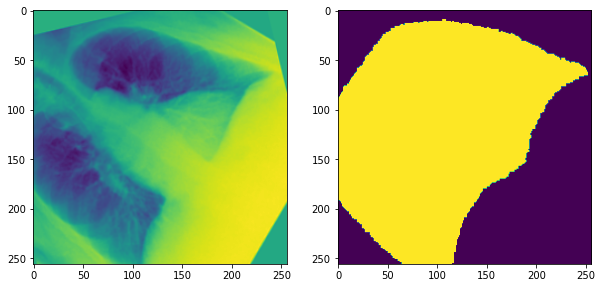

In [22]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [23]:
images.shape

(1500, 256, 256, 1)

In [24]:
masks.shape

(1500, 256, 256, 1)

In [25]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + 'U-Net_mask' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience = 10)

In [26]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=dice_coef_loss,
                  metrics=dice_coef)

In [28]:
batch = 8
epoch = 500

In [29]:
history = model.fit(images,masks,
                    batch_size = batch,
                    epochs = epoch,
                    shuffle = True,
                    callbacks = [tensorboard_callback, early_stop],
                    # sample_weight = importance,
                    validation_split = 0.2)

Epoch 1/500
150/150 [==============================] - 2219s 6s/step - loss: 0.2853 - dice_coef: 0.7147 - val_loss: 0.1849 - val_dice_coef: 0.8147
Epoch 2/500
150/150 [==============================] - 294s 2s/step - loss: 0.2214 - dice_coef: 0.7786 - val_loss: 0.1871 - val_dice_coef: 0.8124
Epoch 3/500
150/150 [==============================] - 294s 2s/step - loss: 0.2159 - dice_coef: 0.7841 - val_loss: 0.1843 - val_dice_coef: 0.8153
Epoch 4/500
150/150 [==============================] - 293s 2s/step - loss: 0.2115 - dice_coef: 0.7885 - val_loss: 0.1999 - val_dice_coef: 0.8003
Epoch 5/500
150/150 [==============================] - 307s 2s/step - loss: 0.2021 - dice_coef: 0.7979 - val_loss: 0.1683 - val_dice_coef: 0.8316
Epoch 6/500
150/150 [==============================] - 311s 2s/step - loss: 0.1908 - dice_coef: 0.8092 - val_loss: 0.1491 - val_dice_coef: 0.8511
Epoch 7/500
150/150 [==============================] - 294s 2s/step - loss: 0.1796 - dice_coef: 0.8204 - val_loss: 0.1636 -

In [39]:
path = '/home/mr1142/Documents/Data/segmentation/'

In [40]:
val_names = os.listdir('/home/mr1142/Documents/Data/segmentation/mascara')

In [41]:
def apply_mask(img, mask):
    img[mask!=1]=0
    return img

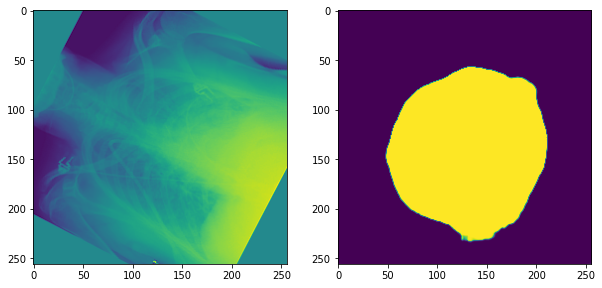

In [54]:
r = np.random.randint(0, len(images))
img = normalize(images[r])
mask = model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [43]:
model.save('/home/mr1142/Documents/Data/models/unet_efficient.h5')